In [3]:
import json, os

os.chdir(r'E:\Documents\ORGANIZADO\Tesis Eólica')
with open('system_config_coquito.json') as f:
    datos = json.load(f)



nombre = datos['Nombre']
Tipo_Turbina = datos['Turbinas']['Enercon_E92']




datos.keys()

dict_keys(['Nombre', 'Turbinas', 'Torres_Meteorologicas', 'Rugosidad', 'Configuracion_Parque', 'Cableado', 'PCC'])

In [4]:
#placeholder for smarter ways to access data
#should be done automatically for each turbine
altura_cubo = Tipo_Turbina['altura_cubo_m']
diam = Tipo_Turbina['diametro_rotor_m']
Vels = Tipo_Turbina['Velocidades_ms-1']
Pot = Tipo_Turbina['Potencia_kW']
C_th = Tipo_Turbina['C_th']

In [5]:
Torres = datos['Torres_Meteorologicas']

long_torres = [None]*len(Torres)
lat_torres = [None]*len(Torres)

for index, num_torre in enumerate(Torres):
    long_torres[index] = Torres[num_torre]['Longitud']
    lat_torres[index] = Torres[num_torre]['Latitud']



In [6]:

Turbinas = datos['Configuracion_Parque']

long_turbinas = [None]*len(Turbinas)
lat_turbinas = [None]*len(Turbinas)
diam_turbinas = [Tipo_Turbina['diametro_rotor_m']]*len(Turbinas)

for index, num_turbina in enumerate(Turbinas):
    long_turbinas[index] = Turbinas[num_turbina]['Longitud']
    lat_turbinas[index] = Turbinas[num_turbina]['Latitud']
    


Text(0, 0.5, 'Latitud [m]')

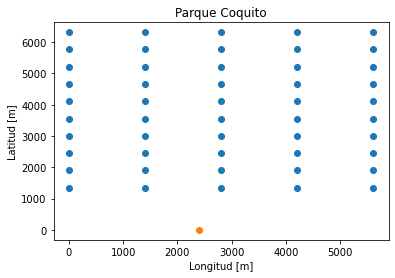

In [7]:
import matplotlib.pyplot as plt

cero_long = min(long_turbinas + long_torres)
cero_lat = min(lat_turbinas + lat_torres)

long_turbinas_m = [(x - cero_long) * 111320 for x in long_turbinas] #1 degree = 111.32 km
lat_turbinas_m = [(y - cero_lat) * 111320 for y in lat_turbinas]
long_torres_m = [(x - cero_long) * 111320 for x in long_torres]
lat_torres_m = [(y - cero_lat) * 111320 for y in lat_torres]


plt.scatter(long_turbinas_m,lat_turbinas_m)
plt.scatter(long_torres_m,lat_torres_m)
plt.title('Parque Coquito')
plt.xlabel('Longitud [m]')
plt.ylabel('Latitud [m]')


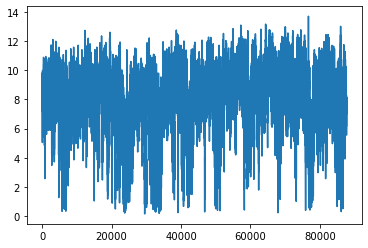

In [8]:
import pandas as pd, matplotlib.pyplot as plt

datos_viento = pd.read_csv('datos_met_F.csv',skiprows=[0],decimal=',') #Torre 1

plt.plot(datos_viento[['wSpeed_98']])


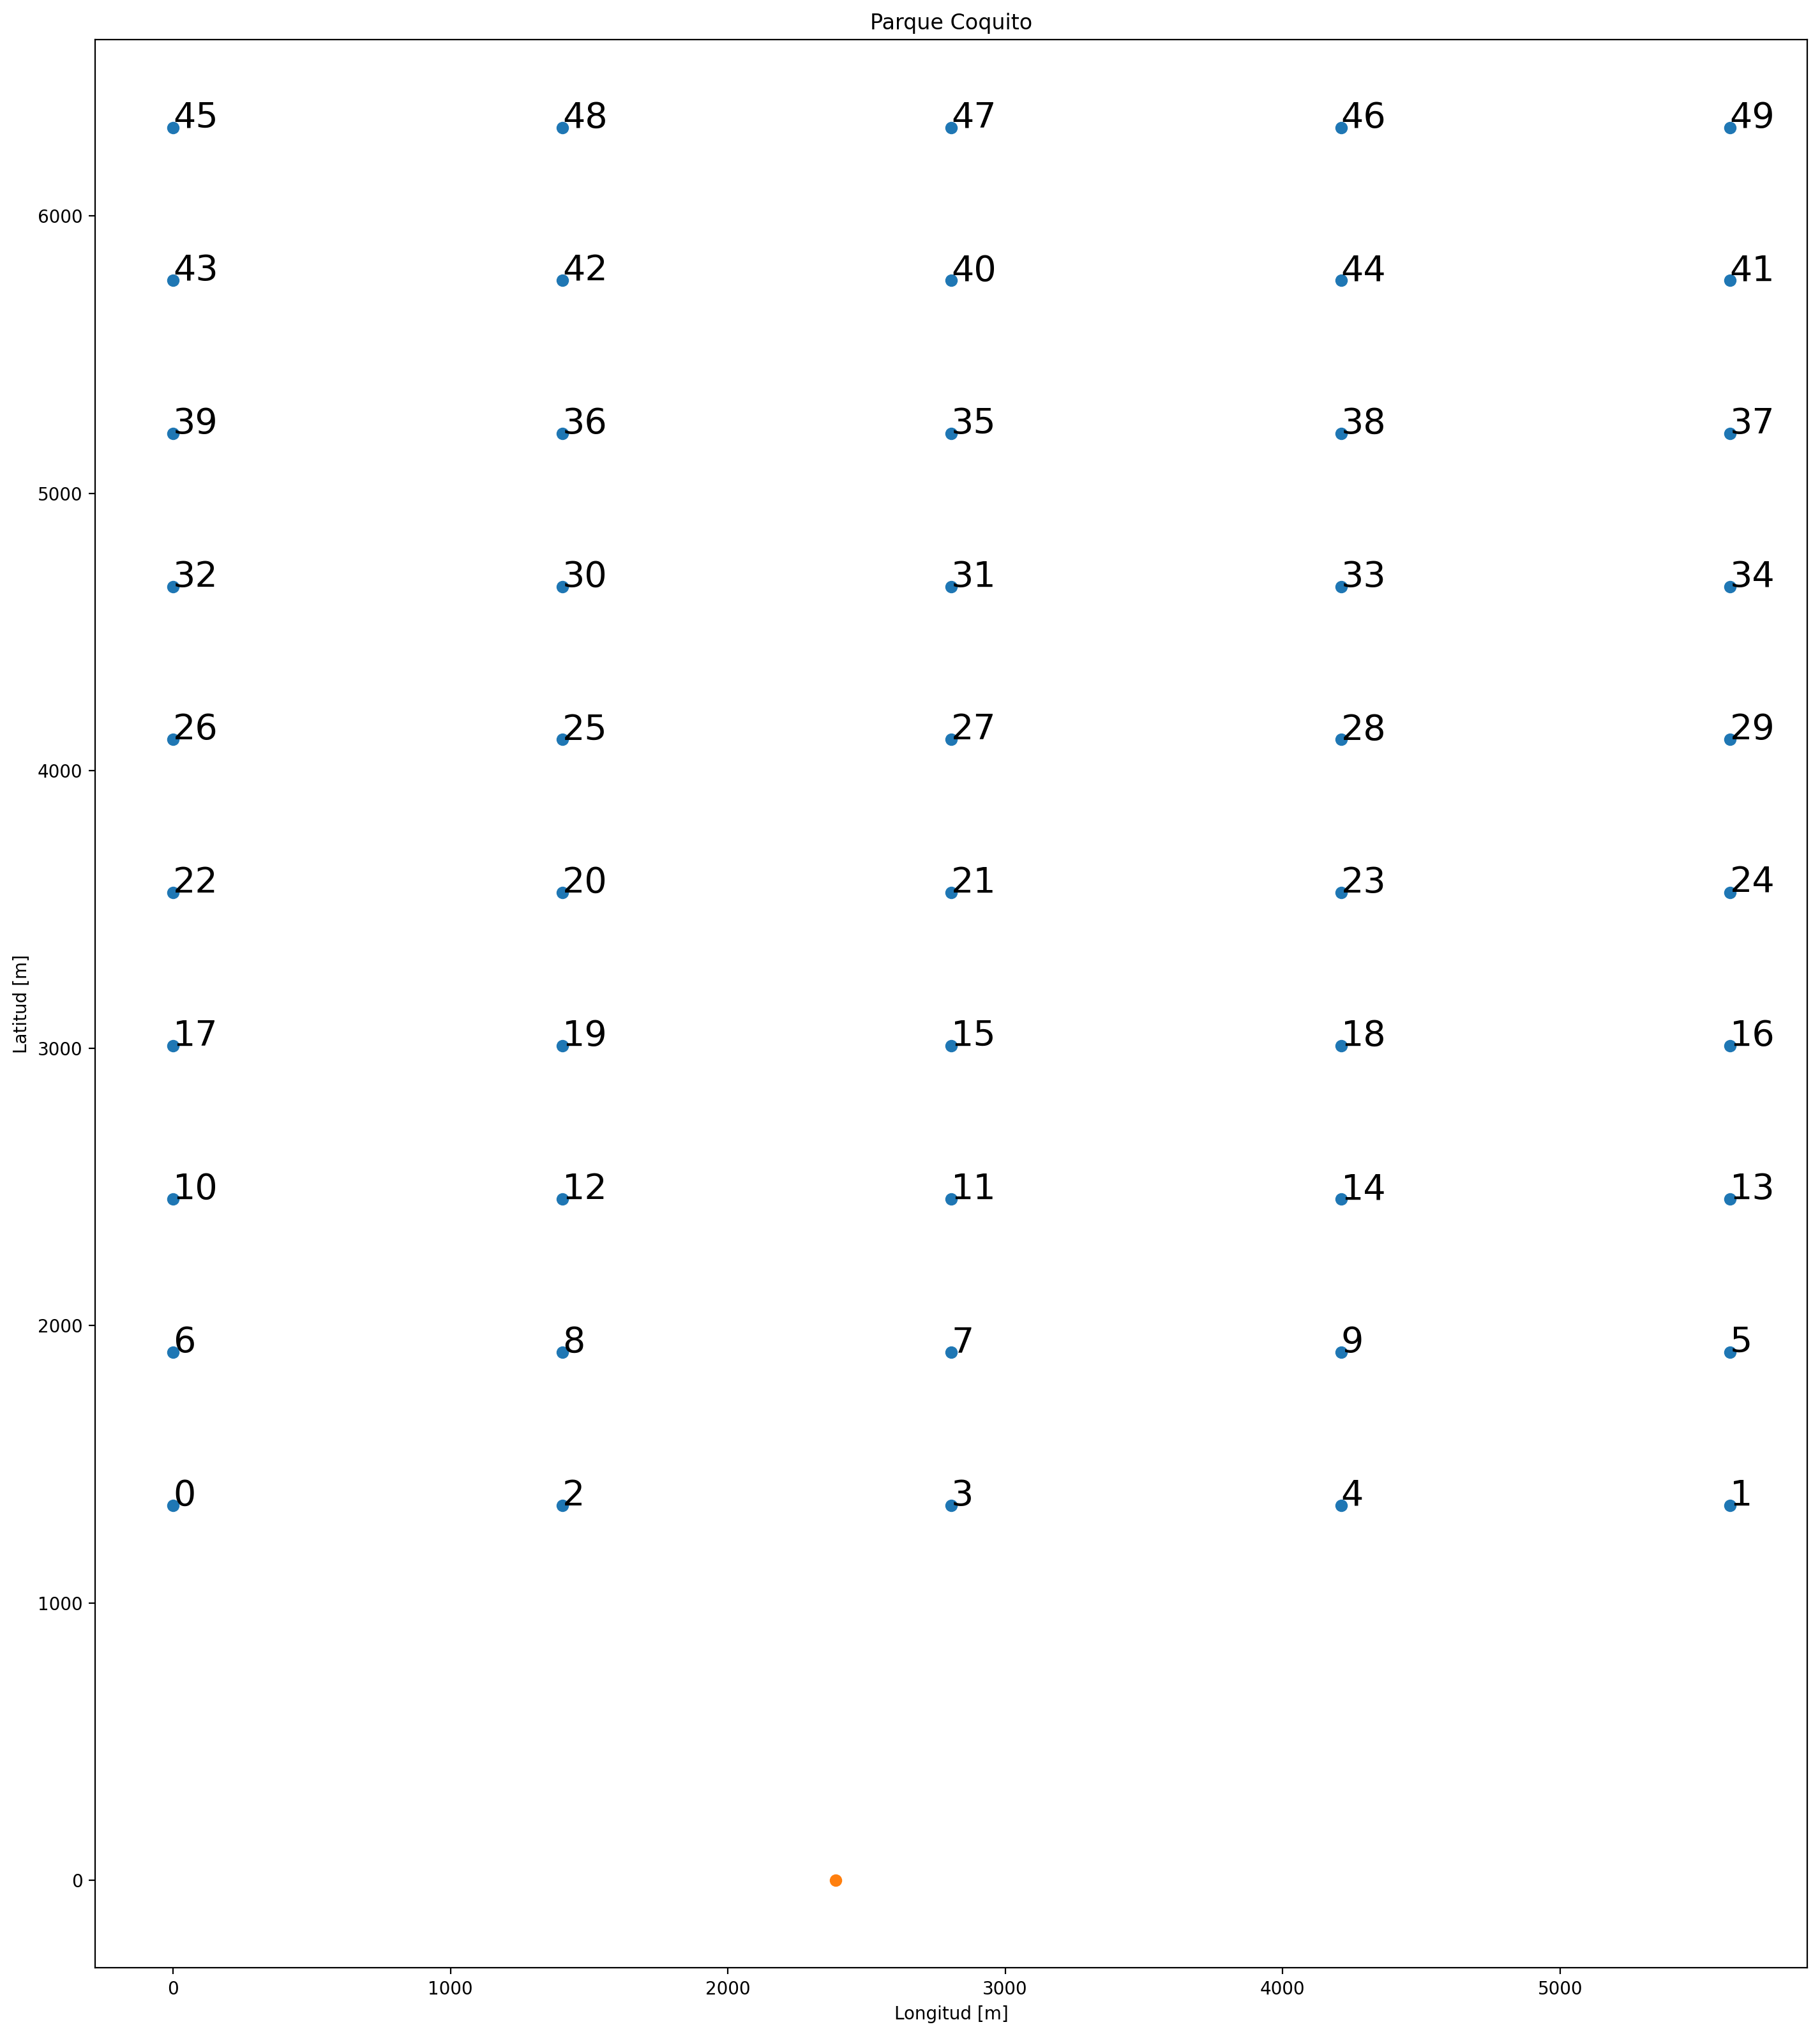

In [97]:
import numpy as np
from operator import itemgetter

def ordenar_turbinas(direccion):
    x = np.array(long_turbinas_m)
    y = np.array(lat_turbinas_m)
    alpha = np.arctan2(y,x)
    # d = np.sqrt([xi**2 + yi**2 for xi,yi in zip(x,y)])*np.cos(alpha - np.radians(direccion))
    d = np.sqrt(x**2 + y**2)*np.cos(alpha - np.radians(direccion))
    # lista = np.append(np.arange(1,len(d)+1),d, axis=1) #si se quiere convertir a array de numpy llamar np.asarray(lista)
    # lista.sort(key=itemgetter(1))
    orden = np.argsort(d)

    return orden



def pintar_turbinas_ordenadas(direccion, idx = False):
    n = ordenar_turbinas(direccion)
    plt.figure(figsize=(20, 20), dpi=200)
    plt.scatter(long_turbinas_m,lat_turbinas_m)
    plt.scatter(long_torres_m,lat_torres_m)
    plt.title('Parque Coquito')
    plt.xlabel('Longitud [m]')
    plt.ylabel('Latitud [m]')
    plt.gca().set_aspect('equal')
    for i, txt in enumerate(n):
        if idx == False:
            plt.annotate(i, (long_turbinas_m[txt], lat_turbinas_m[txt]), size=20)
        else: plt.annotate(i, (long_turbinas_m[i], lat_turbinas_m[i]), size=20)
    
pintar_turbinas_ordenadas(90)

In [10]:
import numpy as np
import matplotlib.pyplot as plt

kw = 0.075 #k_wake, despues nos complicamos
D = diam_turbinas[0]

plt.figure(figsize=(20, 20), dpi=200)
    

def turbinas_afectadas_Parque(turbina,direccion):
    # turbina = 5 #num_turbina en  lista Turbinas
    
    x0 = long_turbinas_m[turbina]
    y0 = lat_turbinas_m[turbina]
    D = diam_turbinas[turbina]

    x = [xi - x0 for xi in long_turbinas_m]
    y = [yi - y0 for yi in lat_turbinas_m]
    ##definir area incidente
    phi = np.radians(direccion)
    gamma = np.arctan2(y,x)
    r = np.sqrt([xi**2 + yi**2 for xi,yi in zip(x,y)])
    omega = phi - gamma
    xbar = r*np.sin(omega)
    ybar = r*np.cos(omega)


    turbinas_afectadas = (xbar<D/2+kw*ybar) & (xbar>-D/2-kw*ybar) & (ybar>0)
            

    return turbinas_afectadas, ybar*turbinas_afectadas

def turbinas_afectadas_rotor(turbina,direccion):
    """
        Calcula las turbinas afectadas por la estela de Jensen, teniendo en cuenta el factor \beta
        Argumentos:
            turbina: número de la turbina cuya estela se va a calcular
            direccion: dirección del viento incidente, en grados
        Retorna:
            turbinas_afectadas: lista binaria con las turbinas que caen dentro de la estela (1) y las que no (0)
            dist_ybar: distancia perpendicular desde la turbina de entrada hasta la turbina en barlovento. 0 si la
            turbina no se ve afectada por la estela
    
    """

    x0 = long_turbinas_m[turbina]
    y0 = lat_turbinas_m[turbina]
    D = diam_turbinas[turbina]

    x = np.array(long_turbinas_m) - x0
    y = np.array(lat_turbinas_m) - y0
    ##definir area incidente
    phi = np.radians(direccion)
    gamma = np.arctan2(y,x)
    r = np.sqrt(x**2+y**2)
    omega = gamma - np.radians(direccion)
    xbar = r*np.sin(omega)
    ybar = r*np.cos(omega)


    # d = np.sqrt(r**2 - ybar**2)
    r_w =  D/2 + kw*ybar #radius of wake
    # L = (r_w**2 - (np.array(diam_turbinas)/2)**2 + d**2)/(2*d)
    # z = np.where(r_w > L, 2*np.sqrt(r_w**2 - L**2) , 0) 
    # #Calculo A_s area interseccion estela con turbina
    # A_s = np.where(z != 0,r_w**2*np.arccos(L/r_w) + (np.array(diam_turbinas)/2)**2*np.arccos((d-L)/r_w) - d*z/2,0)
    # A_r = np.pi*(np.array(diam_turbinas)/2)**2

    turbinas_afectadas = (ybar>0) & (np.abs(xbar)< r_w + np.array(diam_turbinas)/2)
    dist_ybar = turbinas_afectadas*ybar    
    beta = [1]*50

    # beta = np.where(A_s!=0,A_s/A_r,turbinas_afectadas*1)
    # beta = np.abs(beta)

    """
    codigo obsoleto
    revisar nueva version
    referencia areas incidentes https://diego.assencio.com/?index=8d6ca3d82151bad815f78addf9b5c1c6
    """

    return turbinas_afectadas, dist_ybar,beta


def calcular_Ct(v):
    return np.interp(v,Vels,C_th)

def estela_Jensen(U,dir):

    l = ordenar_turbinas(dir)
    n_tur = len(l)
    def_vel = np.ones([n_tur,n_tur]) #deficit velocidad
    vel = np.zeros(len(l))
    for idx,t in enumerate(l):
        # if idx==0: vel[t]=U
        vel[t] = U*(1-np.sqrt(np.sum((1-def_vel[t])**2)))
        v = vel[t]
        Ct = calcular_Ct(v)
        ybar_t = turbinas_afectadas_Parque(t,dir)[1]
        def_vel_t = np.where(ybar_t ==0, 1, 1-(1-np.sqrt(1-Ct))/(1+2*kw*ybar_t/D)**2)
        # def_vel[:] = def_vel_t
        for i in range(0,n_tur-1):
            def_vel[i][t] = def_vel_t[i]
        # if idx==0:def_vel_t = 1-(1-np.sqrt(1-Ct))/(1+2*kw*ybar_t/D)**2
        # if i==10: vel[i] = [vel[i], i]

    return vel


def estela_Jensen_beta(U,dir):

    l = ordenar_turbinas(dir)
    n_tur = len(l)
    def_vel = np.ones([n_tur,n_tur]) #deficit velocidad
    vel = np.zeros(len(l))
    for idx,t in enumerate(l):
        # if idx==0: vel[t]=U
        vel[t] = U*(1-np.sqrt(np.sum((1-def_vel[t])**2)))
        v = vel[t]
        Ct = calcular_Ct(v)
        estela = turbinas_afectadas_rotor(t,dir)
        ybar_t = estela[1]
        beta = estela[2] 
        def_vel_t = np.where(ybar_t ==0, 1, (1-(1-np.sqrt(1-Ct))/(1+2*kw*ybar_t/D)**2)*beta)
        # def_vel[:] = def_vel_t
        for i in range(0,n_tur-1):
            def_vel[i][t] = def_vel_t[i]
        # if idx==0:def_vel_t = 1-(1-np.sqrt(1-Ct))/(1+2*kw*ybar_t/D)**2
        # if i==10: vel[i] = [vel[i], i]

    return vel



def pintar_estela_turbina(turbina,direccion):
    
    
    plt.figure(figsize=(20, 20), dpi=200)
    plt.scatter(long_turbinas_m,lat_turbinas_m,c=turbinas_afectadas_Parque(turbina,direccion)[1])
    plt.scatter(long_torres_m,lat_torres_m)
    plt.title('Parque Coquito')
    plt.xlabel('Longitud [m]')
    plt.ylabel('Latitud [m]')
    plt.gca().set_aspect('equal')
        
    x0 = long_turbinas_m[turbina]
    y0 = lat_turbinas_m[turbina]

    alpha = np.radians(direccion) - np.pi/2


    x1 = x0 - D/2*np.cos(alpha)
    y1 = y0 + D/2*np.sin(alpha)
    x2 = x0 + D/2*np.cos(alpha)
    y2 = y0 - D/2*np.sin(alpha)

    R = 6000
    beta = np.pi/2 - np.arctan(kw) - np.radians(direccion)
    x3 = x1 + R*np.sin(beta)
    y3 = y1 + R*np.cos(beta)
    x4 = x2 + R*np.cos(np.radians(direccion)-np.arctan(kw))
    y4 = y2 + R*np.sin(np.radians(direccion)-np.arctan(kw))

    plt.plot([x3,x1,x2,x4],[y3,y2,y1,y4])
    # plt.plot([x3,x2,x1,x4],[y3,y2,y1,y4]) #for 0<dir<180



<Figure size 4000x4000 with 0 Axes>

In [11]:
def turbinas_afectadas_TurbOPark(turbina,direccion):
    #modelo Turbulence optimized park model, Nygaard et al. 2020
    None

[   0.         6791.52996802 6515.79032802 6239.99502802    0.
    0.            0.            0.            0.            0.
    0.            0.            0.         5026.43695523 4750.75297523
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
 3258.37027211    0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.           -0.        ]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[7.84261183 7.8426271  7.84263734 7.84600429 7.85093895 7.86696256
 7.88202493 8.         8.         8.         7.85575167 7.85576351
 7.85577168 7.855798   7.85583223 7.86700791 7.88204843 8.
 8.      

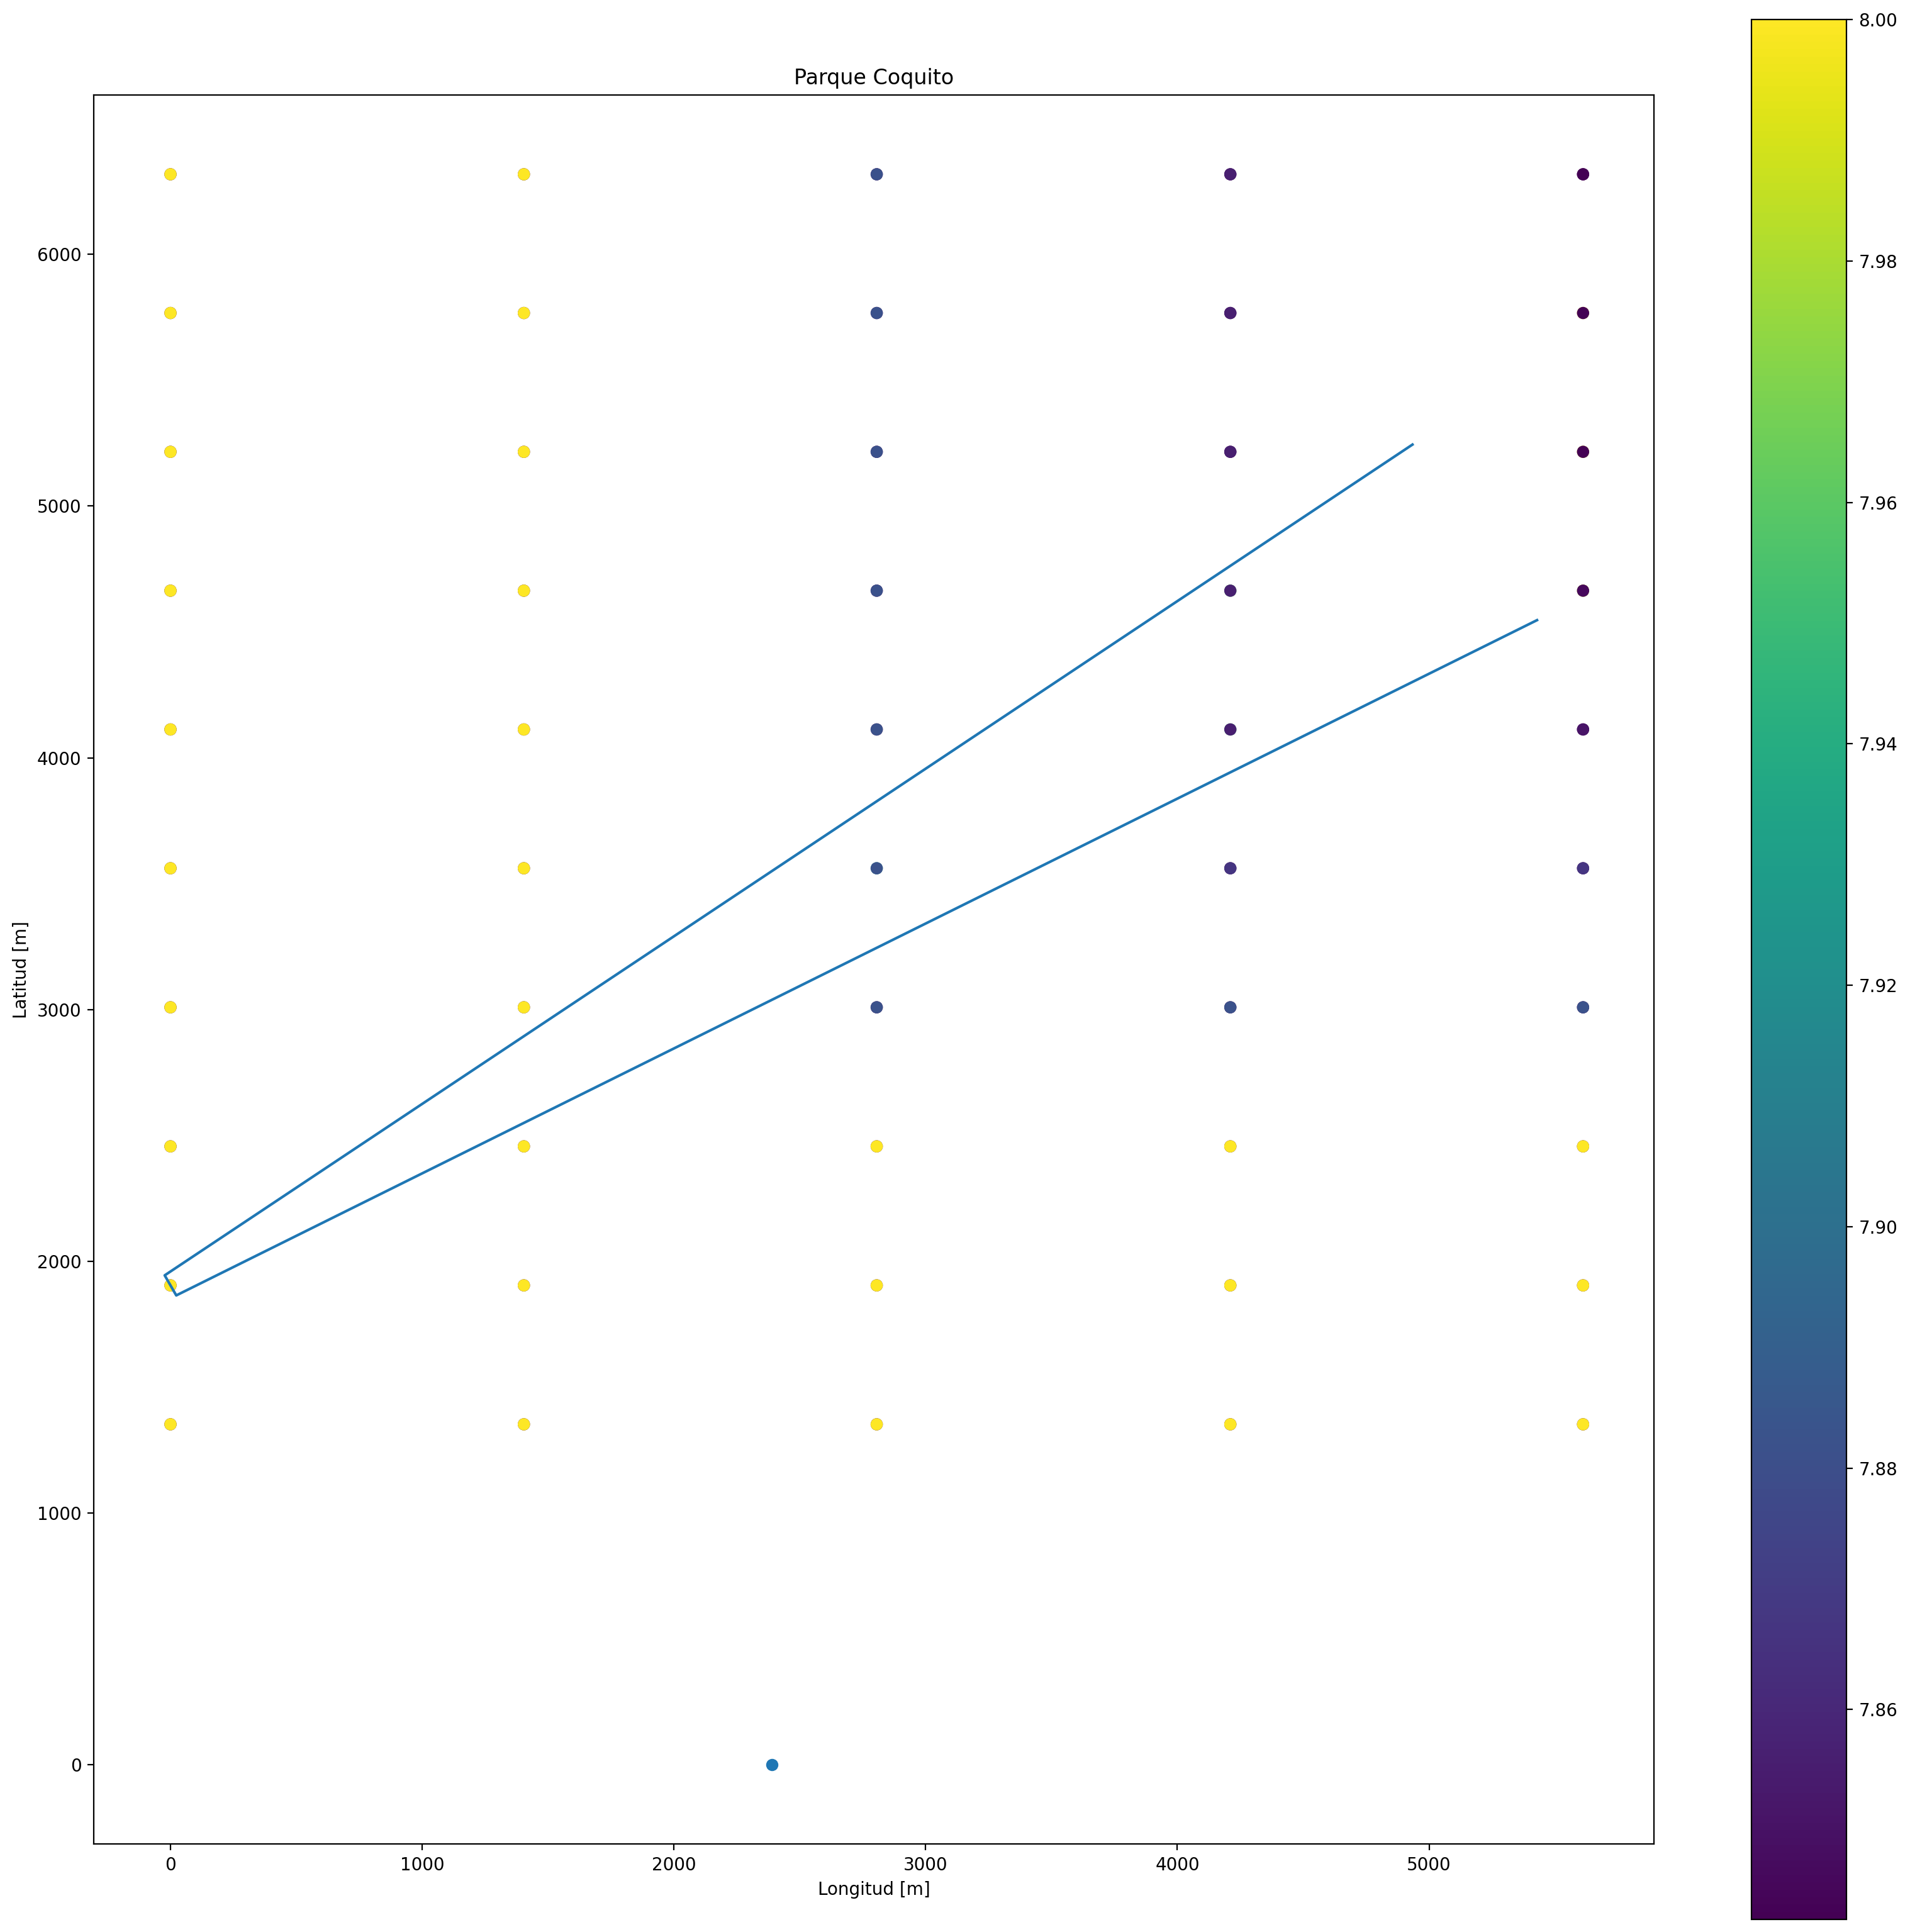

In [12]:
tur = 48
dir = 30
print(turbinas_afectadas_Parque(tur,dir)[1])
print(turbinas_afectadas_rotor(tur,dir)[2])
pintar_estela_turbina(tur,dir)

vel = estela_Jensen_beta(8,30)
plt.scatter(long_turbinas_m,lat_turbinas_m,c=vel)
plt.colorbar()
print(vel)
print(estela_Jensen(8,30))

In [13]:
import numpy as np
def find_nearest(array, value): 
    array = np.asarray(array);     
    idx = (np.abs(array - value)).argmin();     
    return idx


# plt.figure(figsize=(20, 20), dpi=200)
# plt.scatter(long_turbinas_m,lat_turbinas_m,c=vel)
# plt.colorbar()
# def_vel

# y_barras = np.zeros([len(l),len(l)])

vels_parque = datos_viento[['wSpeed_98']].values
dir_parque = datos_viento[['wDir_98']].values

# v = [Velocidades(i) for i in vels_torre.values]

def kWh(v):
    return np.sum([Pot[find_nearest(Vels,v[i])] for i in range(len(v))])

E = 0
E_beta = 0
# for i in range(len(vels_parque)):
for i in range(10):
    E+=kWh(estela_Jensen(vels_parque[i],dir_parque[i]))
    E_beta+=kWh(estela_Jensen_beta(vels_parque[i],dir_parque[i]))



E = E/10000000 #GWh/año
E_beta = E_beta/10000000 #GWh/año
print(E)
print(E_beta)

0.047586300000000005
0.0385919


(87666,)
(500,)
<class 'numpy.ndarray'>


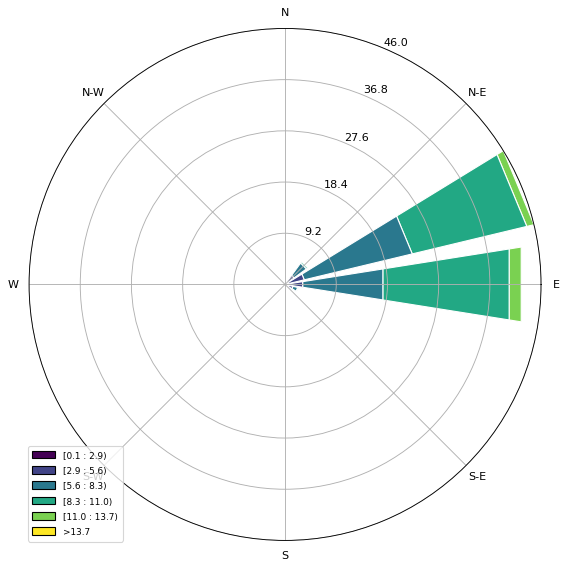

In [14]:
from windrose import WindroseAxes
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Create wind speed and direction variables

ws = vels_parque.reshape((-1,))
wd = dir_parque.reshape((-1,))

ax = WindroseAxes.from_ax()
ax.bar(wd, ws, normed=True, opening=0.8, edgecolor='white')
ax.set_legend()

Modelo Bastankhah (2016)

Cuadrar parámetros $k_y$ y $k_z $ según datos históricos de viento y Potencia.

Modelo no funciona aún

In [187]:
def Modelo_Bastankhah(U, yaw, x,y,z, k_y = 0.1, k_z = 0.1):

    """
    Bastankhah et al. - Experimental and theoretical study of wind turbine wakes in yawed conditions (2016)
    """

    ## definicion de constantes del problema
    ######## = revisar
    d = diam_turbinas[0] #revisar si es necesario convertir al algoritmo dependiente del numero de turbina
    z_h = altura_cubo
    alph = 2.32
    beta = 0.154
    # k_y = 1 ########################
    # k_z = k_y
    I = 0.06 # 6% ############


    yaw = radians(yaw)
    Ct = calcular_Ct(U)
    x_0 = 1/sqrt(2)*d*cos(yaw)*(1+sqrt(1-Ct))/(alph*I + beta*(1-sqrt(1-Ct)))
    sigma_y = k_y*(x-x_0) + d*cos(yaw)/sqrt(8)
    sigma_z = k_z*(x-x_0) + d/sqrt(8)
    theta_ = 0.3*yaw/cos(yaw)*(1-sqrt(1-Ct*cos(yaw)))
    #revisar como ordenar condicional
    #x <= x_0, close wake
    delta_close = theta_*x
    delta_far = theta_*(x_0 + d/14.7*sqrt(cos(yaw)/(k_y*k_z*Ct))*(2.9 + 1.3*sqrt(1-Ct) - Ct)*
        log((1.6+sqrt(Ct))*(1.6*sqrt(8*sigma_y*sigma_z/(d**2*cos(yaw)))-sqrt(Ct))/((1.6-sqrt(Ct))*(1.6*sqrt(8*sigma_y*sigma_z/(d**2*cos(yaw)))+sqrt(Ct)))))
    delta_inft = theta_*(x_0 + d/14.7*sqrt(cos(yaw)/(k_y*k_z*Ct))*(2.9 + 1.3*sqrt(1-Ct) - Ct)*
        log((1.6+sqrt(Ct))/(1.6-sqrt(Ct))))
    delta = delta_far if x>x_0 else delta_close
    def_vel_ = (1-sqrt(1- Ct*cos(yaw)/(8*sigma_y*sigma_z/(d**2))))*exp(-0.5*((y-delta)/sigma_y)**2)*exp(-0.5*((z-z_h)/sigma_z)**2)
    vel = U*(1-def_vel_)
    return vel, def_vel_




def Modelo_Bastankhah_inv(U, dir, turb_incidente, yaw, turb_afectada, k_y = 0.1, k_z= 0.1):
    """
    Calcula la velocidad inducida por una turbina sobre otra
    retorna la velocidad puntual en la nacelle de la turbina afectada
    Asume que no hay turbinas adicionales entre la incidente y la afectada (estelas afectarian el resultado)
        turb_incidente: numero de la turbina incidente segun la lista (int)
        turb_afectada: numero de la turbina afectada segun la lista (int)
    """
    n0 = turb_incidente
    n1 = turb_afectada
    x0 = long_turbinas_m[n0]
    y0 = lat_turbinas_m[n0]
    x1 = long_turbinas_m[n1]
    y1 = lat_turbinas_m[n1]

    
    xrel = x1 - x0
    yrel = y1 - y0
    r = np.sqrt(xrel**2 + yrel**2)
    omega = radians(dir) - np.arctan2(yrel,xrel)
    y = r*np.sin(omega)
    x = r*np.cos(omega)
    
    z_h = altura_cubo
    return Modelo_Bastankhah(U,yaw,x,y,z_h, k_y, k_z)[0]


k_y = 0.1
k_z = 0.1
alph = 2.32
beta = 0.154
I = 0.06 # 6% ############
d = diam_turbinas[0] #revisar si es necesario convertir al algoritmo dependiente del numero de turbina

yaw = radians(0)
Ct = calcular_Ct(10)
x_0 = 1/sqrt(2)*d*cos(yaw)*(1+sqrt(1-Ct))/(alph*I + beta*(1-sqrt(1-Ct)))
x = 551
sigma_y = k_y*(x-x_0) + d*cos(yaw)/sqrt(8)
sigma_z = k_z*(x-x_0) + d/sqrt(8)
log1 = log((1.6+sqrt(Ct))*(1.6*sqrt(8*sigma_y*sigma_z/(d**2*cos(yaw)))-sqrt(Ct))/((1.6-sqrt(Ct))*(1.6*sqrt(8*sigma_y*sigma_z/(d**2*cos(yaw)))+sqrt(Ct))))
log2 = log((1.6+sqrt(Ct))*(1.6*sqrt(8*sigma_y*sigma_z/(d**2*cos(yaw)))-sqrt(Ct))/((1.6-sqrt(Ct))*(1.6*sqrt(8*sigma_y*sigma_z/(d**2*cos(yaw)))+sqrt(Ct))))
print(x_0)
print(sigma_y)
print(log1-log2)

475.99330502714633
40.02758143186655
0.0


0.4614835192865495
458.69476339022174
551.9245600000268


C:\Users\user\AppData\Local\Temp/ipykernel_15636/3381059753.py:32: RuntimeWarning: invalid value encountered in sqrt
  def_vel_ = (1-sqrt(1- Ct*cos(yaw)/(8*sigma_y*sigma_z/(d**2))))*exp(-0.5*((y-delta)/sigma_y)**2)*exp(-0.5*((z-z_h)/sigma_z)**2)


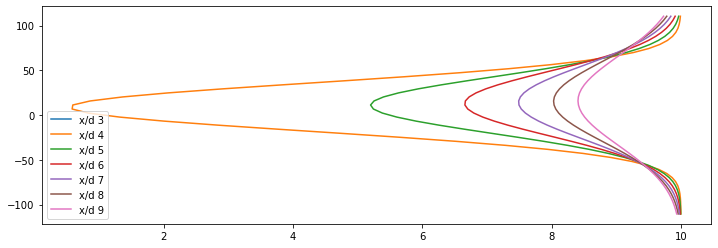

In [155]:
from numpy import sqrt, cos, radians, log, exp

U = 10
yaw = 10
z_h = altura_cubo
d = diam_turbinas[0]

xrange = d*np.arange(3,10)
Ct = calcular_Ct(U)
alph = 2.32
beta = 0.164
I = 0.06
print((1-sqrt(1-Ct)))
yaw = radians(yaw)
x_0 = 1/sqrt(2)*d*cos(yaw)*(1+sqrt(1-Ct))/(alph*I + beta*(1-sqrt(1-Ct)))
print(x_0)
print(lat_turbinas_m[8] - lat_turbinas_m[9])
ky = np.linspace(0.001, 1, 10)
x_grid, ky_grid = np.meshgrid(xrange, ky)
sigma_y = ky_grid*(x_grid-x_0) + d*cos(yaw)/sqrt(8)
sigma_z = (xrange-x_0) + d/sqrt(8)
# print(sigma_y)
yrange = np.linspace(-1.2,1.2)*d
mat = np.zeros((len(xrange),len(yrange)))
def_vel_mat = np.zeros((len(xrange),len(yrange)))
k = 0.05
for i,x in enumerate(xrange):
    for j,y in enumerate(yrange):
        mat[i,j] = Modelo_Bastankhah(U,np.degrees(yaw),x,y,z_h, k_y=k, k_z = k)[0]
        def_vel_mat[i,j] = Modelo_Bastankhah(U,np.degrees(yaw),x,y,z_h, k_y=k, k_z = k)[1]
    # plt.plot(xrange/d,sigma_y[:][i])
# print(Modelo_Bastankhah(U,yaw, 5*d, 0, z_h ))
# print(mat[6])


fig, ax = plt.subplots(figsize = (12,4))

scale = np.max(mat[0])-np.min(mat[0])

for i,x in enumerate(xrange):
    plt.plot(mat[i], yrange, label="x/d {:g}".format(x/d))
    plt.legend()
    if i==0:
        pos = x
        # print(mat[i]-np.min(mat[i]))
        # ax.plot(x/d + (mat[i]-np.min(mat[i]))/scale, yrange)



Modelo Bastankhah en granja. Suposición 1) Potencia depende de velocidad en la nacelle (promedio sobre área de rotor por implementar). Suposición 2) Superposición de deficits por energía cinética (no lineal) dado por $u(x,y) = u_\infty - \sqrt{\sum_{i}^{N_f} {\Delta u_i}^2}$

In [188]:

k_y = 1
k_z = 1

x = k_y, k_z

k = 0.1

print(Modelo_Bastankhah_inv(10, 90, 49, 0, 48, k, k))

def windfarm_Bastankhah(U, dir, yaw_vec, k_y = k, k_z=k):
    """
    calcula las velocidades de cada turbina utilizando el modelo de bastankhah
    """
    yaw_vec = np.array(yaw_vec)
    # print(yaw_vec[10])
    l = ordenar_turbinas(dir)
    n_tur = len(l)
    vel = np.zeros(len(l))
    def_vel = np.zeros([n_tur,n_tur]) #deficit velocidad
    for idx,t in enumerate(l):
        vel[t] = U*(1-np.sqrt(np.sum((def_vel[t])**2)))
        # if idx==1: print(def_vel)
        for i in range(idx+1,n_tur):
            vel_i = Modelo_Bastankhah_inv(U,dir,t,yaw_vec[t],l[i], k_y, k_z)
            print(t, l[i])
            print(vel_i)
            def_vel[t][l[i]] = 1 - vel_i/U
            
    return vel


windfarm_Bastankhah(10,90, [0]*50)


def pot_Bastankhah(x):

    k_y = x[0]
    k_z = x[1]
    
    w_speed = vels_parque.reshape((-1,))
    w_dir = dir_parque.reshape((-1,))

    
    E = 0
    E2 = 0
    for i in range(1):
        E+=kWh(windfarm_Bastankhah(w_speed[i],w_dir[i], [0]*50, k_y, k_z))
        E2+=kWh([w_speed[i]]*50)
    return E

print(type([0.01,0.01]))

k = np.logspace(-3.0, 2.0, num= 15)
pots = np.zeros(len(k))
for i,ki in enumerate(k):
    # print(type(ki))
    pots[i] = pot_Bastankhah([ki,ki])

7.302860194336268
49 9
nan
49 39
nan
49 29
nan
49 19
nan
49 8
10.0
49 48
7.302860194336268
49 28
10.0
49 38
10.0
49 18
10.0
49 47
9.577941112631503
49 27
10.0
49 37
10.0
49 7
10.0
49 17
10.0
49 26
10.0
49 6
10.0
49 46
9.832990784072269
49 16
10.0
49 36
10.0
49 35
9.999999999992975
49 25
10.0
49 45
9.910950702872094
49 15
10.0
49 5
10.0
49 34
9.999999971266208
49 44
9.944702486481496
49 24
10.0
49 14
10.0
49 4
10.0
49 33
9.999998038626464
49 23
10.0
49 43
9.962343467708376
49 13
10.0
49 3
10.0
49 22
9.99999999999999
49 32
9.999978580931945
49 2
10.0
49 12
10.0
49 42
9.972715498891832
49 21
9.99999999999178
49 1
10.0
49 31
9.999908465955441
49 41
9.979323234183092
49 11
10.0
49 40
9.983789125949215
49 10
10.0
49 20
9.999999999311509
49 30
9.99976884495485
49 0
10.0
9 39
nan
9 29
nan
9 19
nan
9 8
7.302860194336268
9 48
10.0
9 28
10.0
9 38
10.0
9 18
10.0
9 47
10.0
9 27
10.0
9 37
10.0
9 7
9.577941112631503
9 17
10.0
9 26
10.0
9 6
9.832990784072269
9 46
10.0
9 16
10.0
9 36
10.0
9 35
10.0
9 2

C:\Users\user\AppData\Local\Temp/ipykernel_15636/3854669279.py:28: RuntimeWarning: invalid value encountered in log
  log((1.6+sqrt(Ct))*(1.6*sqrt(8*sigma_y*sigma_z/(d**2*cos(yaw)))-sqrt(Ct))/((1.6-sqrt(Ct))*(1.6*sqrt(8*sigma_y*sigma_z/(d**2*cos(yaw)))+sqrt(Ct)))))
C:\Users\user\AppData\Local\Temp/ipykernel_15636/3854669279.py:32: RuntimeWarning: invalid value encountered in sqrt
  def_vel_ = (1-sqrt(1- Ct*cos(yaw)/(8*sigma_y*sigma_z/(d**2))))*exp(-0.5*((y-delta)/sigma_y)**2)*exp(-0.5*((z-z_h)/sigma_z)**2)


9.944650413948086
7 12
9.999999970020978
7 42
10.0
7 21
10.0
7 1
9.962316882046174
7 31
10.0
7 41
10.0
7 11
9.999997976299635
7 40
10.0
7 10
9.999978103550392
7 20
9.99999999999999
7 30
10.0
7 0
9.972692546945819
17 26
10.0
17 6
10.0
17 46
10.0
17 16
7.311702069424987
17 36
10.0
17 35
10.0
17 25
10.0
17 45
10.0
17 15
9.578544811731662
17 5
10.0
17 34
10.0
17 44
10.0
17 24
10.0
17 14
9.83291605735287
17 4
10.0
17 33
10.0
17 23
9.999999999993372
17 43
10.0
17 13
9.91083448408191
17 3
9.999999999992543
17 22
9.99999997214406
17 32
10.0
17 2
9.999999970020978
17 12
9.944650413948086
17 42
10.0
17 21
9.99999807509612
17 1
9.999997976299635
17 31
10.0
17 41
10.0
17 11
9.962316882046174
17 40
10.0
17 10
9.972692546945819
17 20
9.999978883912146
17 30
9.99999999999999
17 0
9.999978103550392
26 6
nan
26 46
nan
26 16
nan
26 36
nan
26 35
10.0
26 25
7.309937489255792
26 45
10.0
26 15
10.0
26 5
10.0
26 34
10.0
26 44
10.0
26 24
9.577638772735646
26 14
10.0
26 4
10.0
26 33
10.0
26 23
9.83266660467892

C:\Users\user\AppData\Local\Temp/ipykernel_15636/3854669279.py:28: RuntimeWarning: invalid value encountered in log
  log((1.6+sqrt(Ct))*(1.6*sqrt(8*sigma_y*sigma_z/(d**2*cos(yaw)))-sqrt(Ct))/((1.6-sqrt(Ct))*(1.6*sqrt(8*sigma_y*sigma_z/(d**2*cos(yaw)))+sqrt(Ct)))))
C:\Users\user\AppData\Local\Temp/ipykernel_15636/3854669279.py:32: RuntimeWarning: invalid value encountered in sqrt
  def_vel_ = (1-sqrt(1- Ct*cos(yaw)/(8*sigma_y*sigma_z/(d**2))))*exp(-0.5*((y-delta)/sigma_y)**2)*exp(-0.5*((z-z_h)/sigma_z)**2)


(7.288067561588488, 0.2711932438411513)
(7.302860194336268, 0.2697139805663732)
7.302860194336268
nan
6.721586369927137


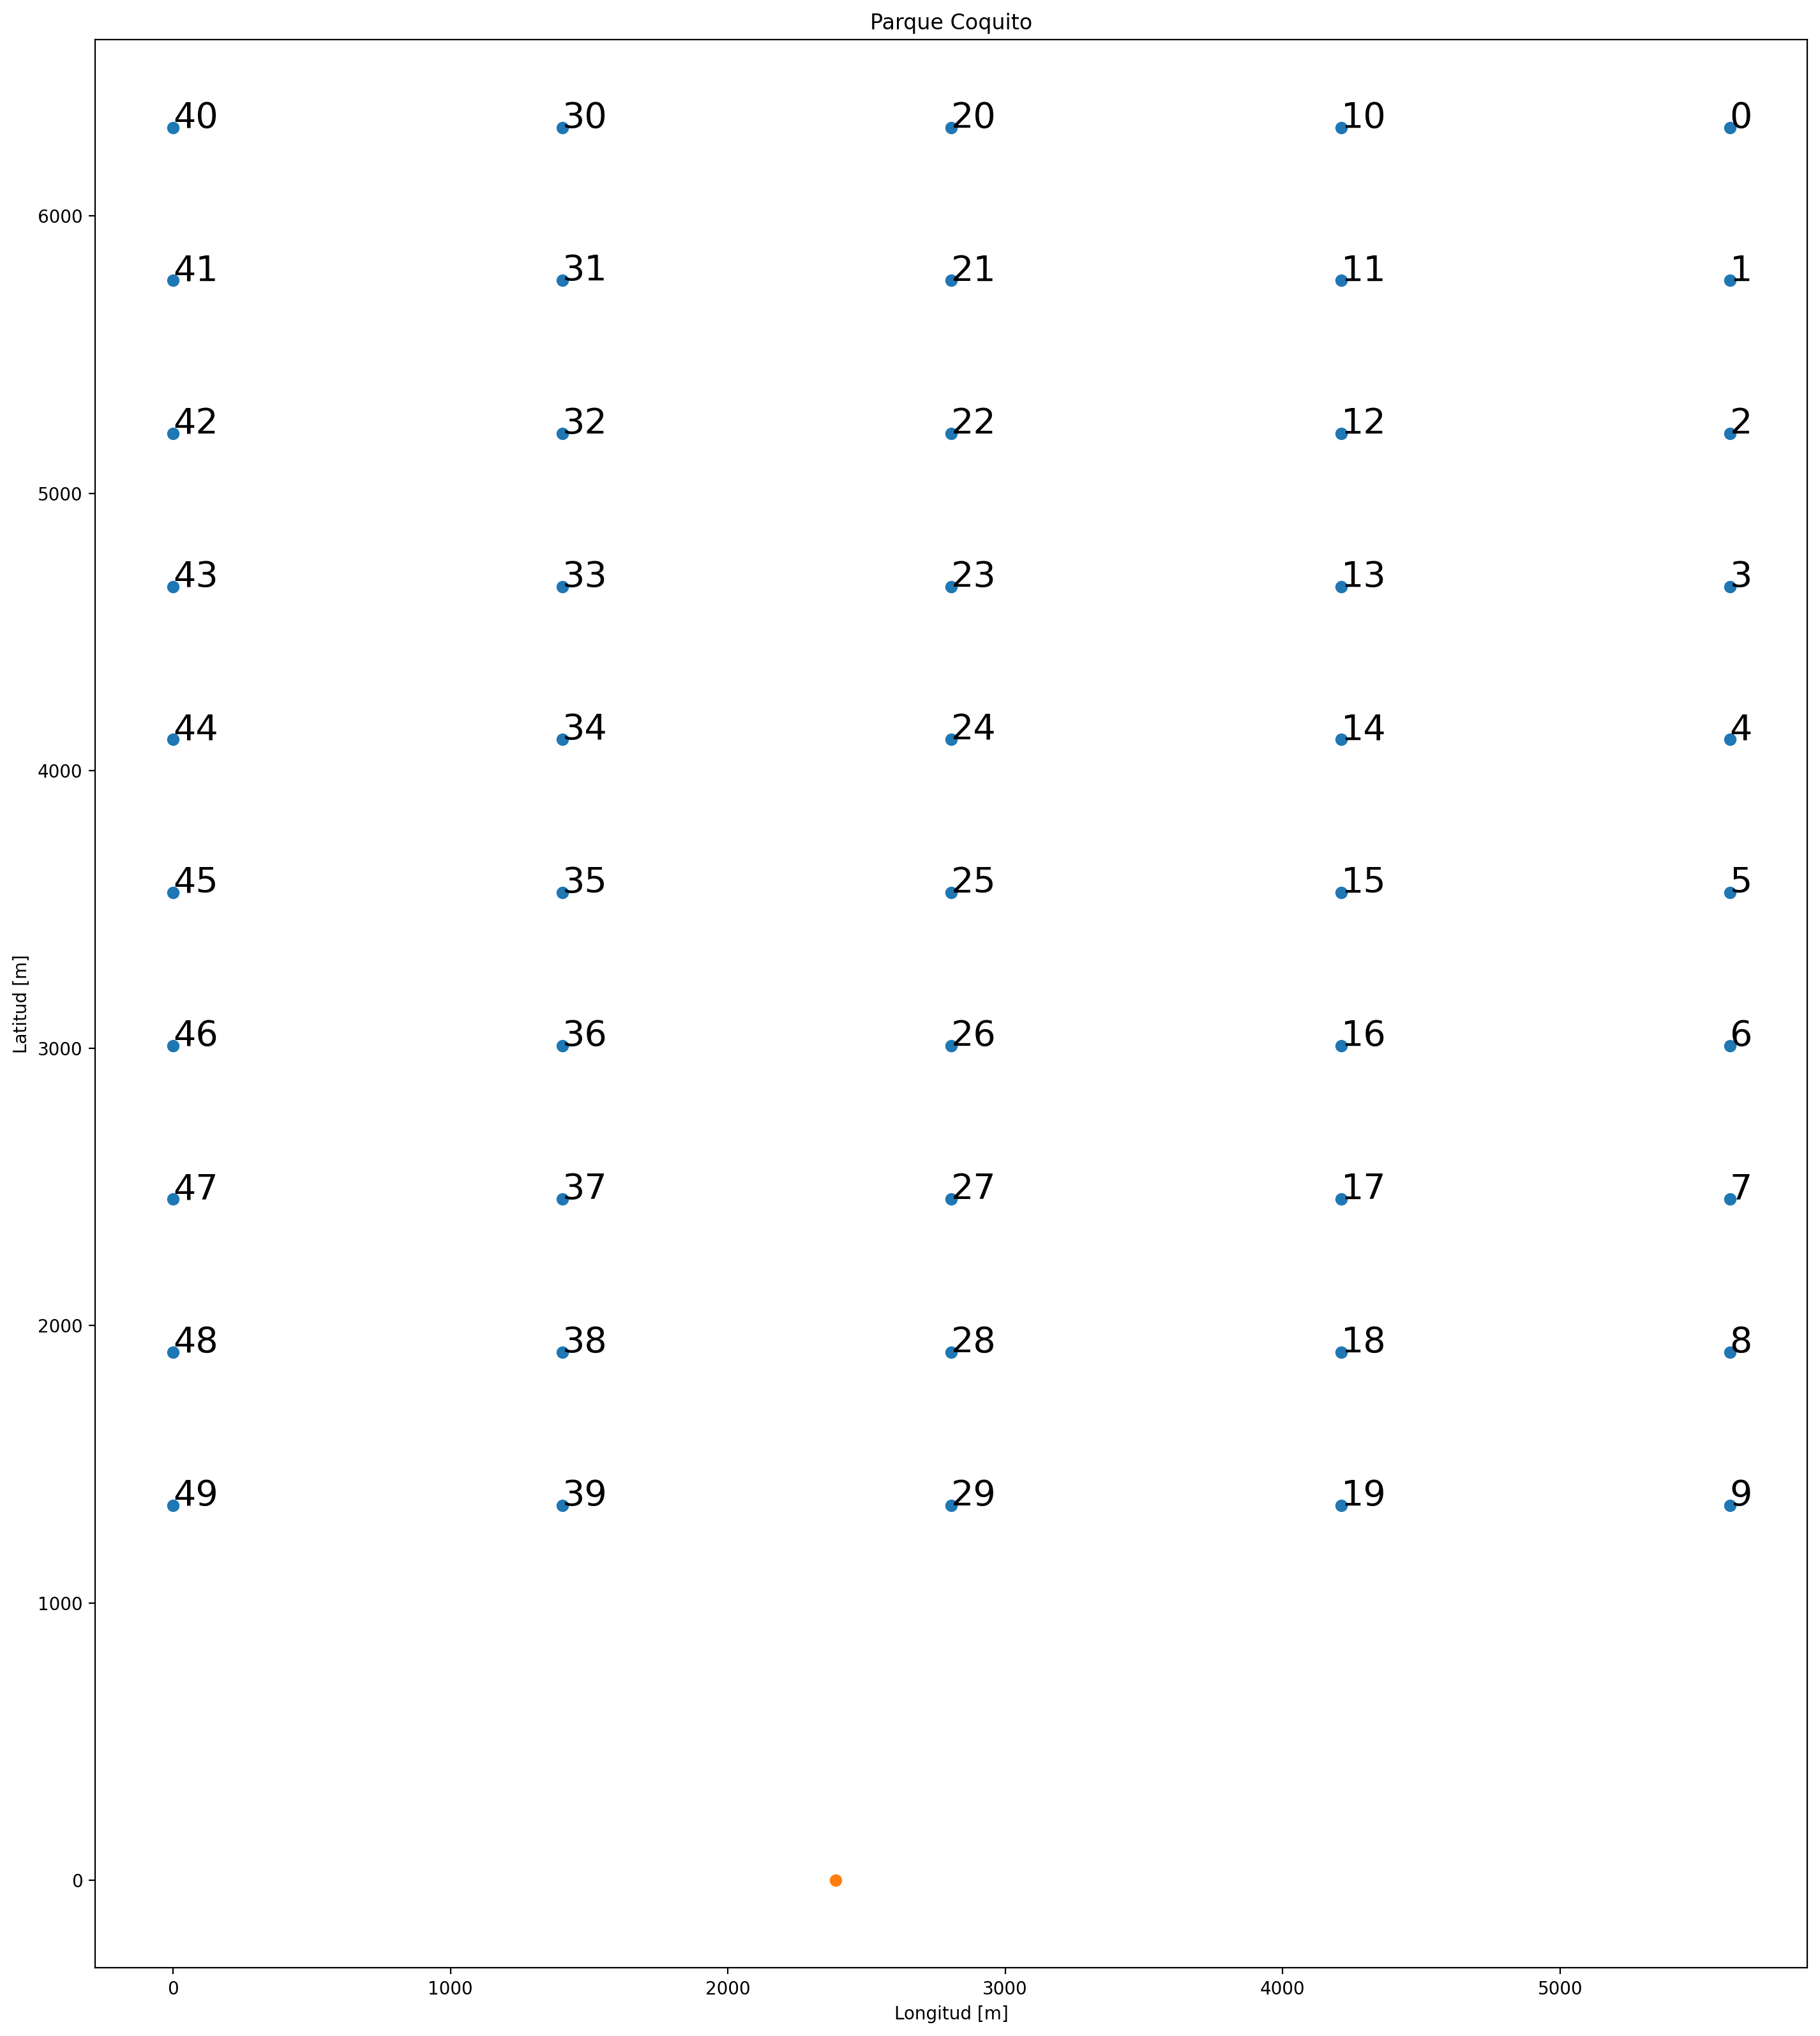

In [192]:
dir = 90
l = ordenar_turbinas(dir)
# for idx,t in enumerate(l):
    # print(idx,t)
    # print(l[idx])
U =10
dir = 90
yaw_vec = [0]*50
yaw_vec = np.array(yaw_vec)
l = ordenar_turbinas(dir)
n_tur = len(l)
vel = np.zeros(len(l))
def_vel = np.zeros([n_tur,n_tur]) #deficit velocidad
for idx,t in enumerate(l):
    vel[t] = U*(1-np.sqrt(np.sum((def_vel[t])**2)))
    # if idx==1: print(def_vel)
    for i in range(idx+1,n_tur):
        vel_i = Modelo_Bastankhah_inv(U,dir,t,yaw_vec[t],l[i])
        # print(vel_i)
        def_vel[t][l[i]] = 1 - vel_i/U


print(Modelo_Bastankhah(U, 0, 551, 0, altura_cubo))
n0 = 49
n1 = 48
x0 = long_turbinas_m[n0]
y0 = lat_turbinas_m[n0]
x1 = long_turbinas_m[n1]
y1 = lat_turbinas_m[n1]


xrel = x1 - x0
yrel = y1 - y0
r = np.sqrt(xrel**2 + yrel**2)
omega = radians(dir) - np.arctan2(yrel,xrel)
x = r*np.sin(omega)
y = r*np.cos(omega)

z_h = altura_cubo
print(Modelo_Bastankhah(10,0,lat_turbinas_m[48]-lat_turbinas_m[49],0,z_h,0.1,0.1))
print(Modelo_Bastankhah_inv(U, 90, 49, 0, 48, 0.1, 0.1))
print(U*(1-np.sqrt(np.sum((def_vel[49])**2))))
k = 0.001
print(Modelo_Bastankhah_inv(U,dir,9,0,0, k_y = k, k_z = k))
pintar_turbinas_ordenadas(90, idx = True)